In [124]:
import pandas as pd
import requests
import datetime as dt
from typing import List
import matplotlib.pyplot as plt

In [166]:
class ons_data:
    """Classe destinada à leitura dos dados de carga da ONS
    """
    def __init__(self, freq: str, ano_inicio: int, ano_fim: int, idreg: str=None):
        """
        Args:
            freq (str): frequência da série. ["h","d"]
            ano_inicio (int): ano inicial de extração.
            ano_fim (int): ano final de extração.
            idreg (str): sub-região. ['N', 'NE', 'S', 'SE']
        """
        self.freq = freq
        self.ano_inicio = ano_inicio
        self.ano_fim = ano_fim
        self.idreg = idreg
        self.data = pd.DataFrame()
        self.missing_dates = []
        self.datas_estranhas = []
        self.data_dt_inserted = pd.DataFrame()
        self.data_dir = "../../../data/"

    def read(self) -> pd.DataFrame:
        """Função para ler arquivos "csv" já presentes no diretório de dados.

        Args:
            

        Returns:
            pd.DataFrame: série de carga elétrica no período entre ano_inicio e ano_fim.
        """
        if self.freq == "h":
            path = "".join([self.data_dir,"hourly_load.csv"])
        elif self.freq == "d":
            path = "".join([self.data_dir,"daily_load.csv"])
        df = pd.read_csv(path, sep=";", decimal=",", parse_dates=["date"])
        if not self.idreg:
            idreg = df["id_reg"].unique()
        else:
            idreg = [self.idreg]
        df = df[df["id_reg"].isin(idreg)]
        df.set_index("date", inplace=True)
        self.data = df
        return df

    def update(self, printer=False, write: bool=False) -> pd.DataFrame:
        """Função para atualizar os arquivos no diretório de dados.

        Args:
            printer (bool, optional): Informa o progresso do download ano a ano. Defaults to False.
            write (bool, optional): Escreve o arquivo no diretório de dados. Defaults to False.

        Raises:
            Exception: Frequência não está na lista de arquivos disponíveis.

        Returns:
            pd.DataFrame: série atualizada de carga elétrica no período entre ano_inicio e ano_fim.
        """
        if self.freq == "h":
            url = "https://ons-dl-prod-opendata.s3.amazonaws.com/dataset/curva-carga-ho/CURVA_CARGA_{}.csv"
            date_format = "%Y-%m-%d %H:%M:%S"
        elif self.freq == "d":
            url = "https://ons-dl-prod-opendata.s3.amazonaws.com/dataset/carga_energia_di/CARGA_ENERGIA_{}.csv"
            date_format = "%Y-%m-%d"
        else:
            raise Exception("Frequência não reconhecida. Utilize 'hourly' ou 'daily'.")
        get0 = requests.get(url.format(self.ano_inicio)).status_code # verify = False (autenticação)
        getn = requests.get(url.format(self.ano_fim)).status_code 
        if (get0 == 200) and (getn == 200): # 200: página (ano) disponível
            # concatenar arquivos de cada ano em um único dataframe
            df = pd.DataFrame()
            for ano in range(self.ano_inicio, self.ano_fim + 1):
                if printer:
                    print(f"Lendo ano {ano}...")
                df2 = pd.read_csv(url.format(ano), sep = ";")
                df = pd.concat([df, df2])
            df.columns = ["id_reg", "desc_reg", "date", "load_mwmed"]
            df.loc[:, "date"] = pd.to_datetime(df.loc[:, "date"], format = date_format)
            df.sort_values(by = "date", inplace = True)
            df.set_index("date", inplace=True)
            if write:
                full_path = "".join([self.data_dir,f"{self.freq}_load.csv"])
                df.to_csv(full_path, sep=";", decimal=",")
            self.data = df
            return df
        else:
            print("Ano não disponível.")
    
    def check_date_column(self, printer=False) -> List[dt.datetime]:
        """Verifica datas faltantes no intervalo

        Args:
            _freq (str): frequência da série
            printer (bool, optional): informa as datas faltantes em tela. Defaults to False.

        Returns:
            List[dt.datetime]: lista de datas faltantes
        """
        date_col = self.data.reset_index()["date"]
        _dt_range = pd.date_range(date_col.min(), date_col.max(), freq=self.freq)
        missing_dates_ = _dt_range.difference(date_col)
        missing_list = missing_dates_.to_list()
        dts_extras = date_col[~(date_col.isin(_dt_range))].to_list()
        if printer:
            print("Datas faltantes:\n", missing_list)
            print("Datas estranhas:\n", dts_extras)
        self.datas_estranhas = dts_extras
        self.missing_dates = missing_list
        return missing_list
    
    def insert_missing_dates(self, printer=False):
        y = self.data.reset_index()
        missing = pd.DataFrame(self.missing_dates, columns=["date"])
        y = pd.concat([y, missing], ignore_index=True)
        y.loc[:,"date"] = pd.to_datetime(y.loc[:,"date"])
        y.set_index("date", inplace=True)
        y.sort_index(inplace=True)
        faltantes = check_date_column(y, _freq='h')
        if printer:
            print("Datas faltantes após transformação:", faltantes)
        self.data_dt_inserted = y
        return y

    def get_data_description(self, plot=False):
        data = self.data_dt_inserted
        print("Valores vazios:")
        n_missing = data["load_mwmed"].isna().sum()
        print(data.isna().sum())
        print("\nValor mínimo:", data["load_mwmed"].min())
        print("Valor máximo:", data["load_mwmed"].max())
        if plot==True:
            missing_idx = data[data["load_mwmed"].isna()].index
            fig, ax = plt.subplots(figsize=(15,5))
            plt.plot(pd.to_datetime(data.index), data["load_mwmed"])
            for data_faltante in missing_idx:
                plt.axvline(x=data_faltante, color='red', linestyle='--')
            
            plt.title(f"Valores vazios: {n_missing}")
            plt.show()

C:\Users\user\AppData\Local\Temp\ipykernel_13428\3304367742.py:114: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  y.loc[:,"date"] = pd.to_datetime(y.loc[:,"date"])


Valores vazios:
id_reg         14
desc_reg       14
load_mwmed    921
dtype: int64

Valor mínimo: 0.0
Valor máximo: 52889.43499999


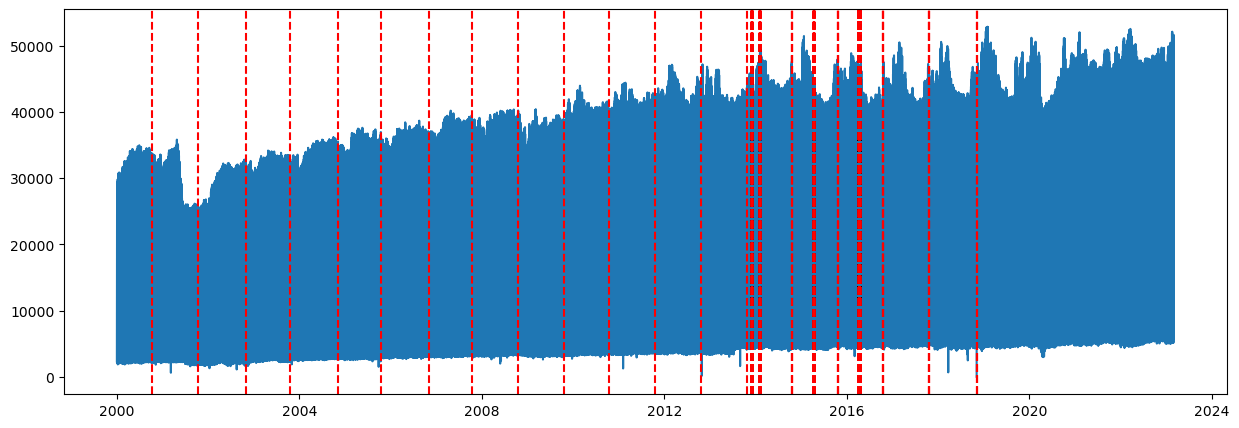

In [162]:
data = ons_data(freq='h', ano_inicio=2000, ano_fim=2023)
df = data.read()
data.check_date_column()
data.insert_missing_dates()
data.get_data_description(plot=True)

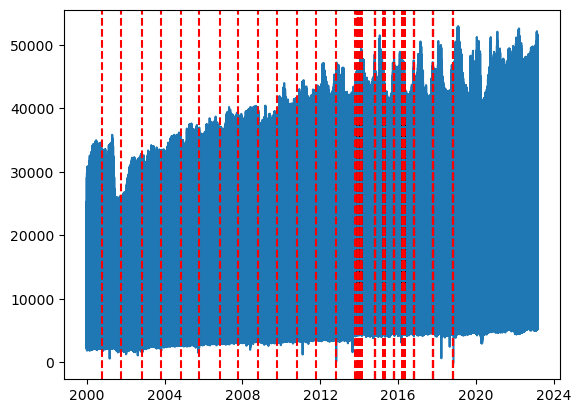

In [149]:
values = data.data_dt_inserted.load_mwmed
missing = values[values.isna()].index
fig, ax = plt.subplots()
plt.plot(pd.to_datetime(df.index), df.load_mwmed)
for data_faltante in missing:
    plt.axvline(x=data_faltante, color='red', linestyle='--')
plt.show()

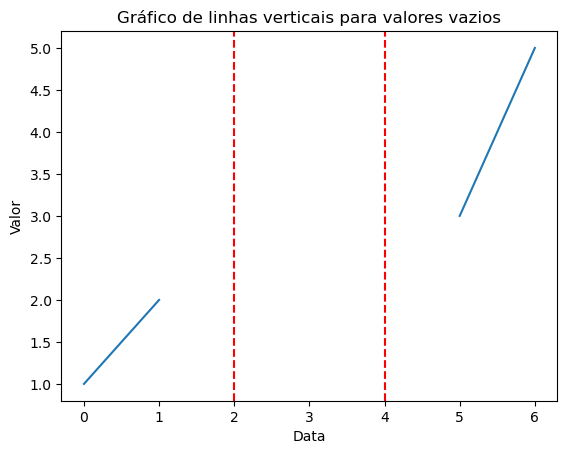

In [138]:
def grafico_linhas_verticais_valores_vazios(s):
    # Encontra as datas com valores faltantes
    datas_faltantes = s[s.isnull()].index

    # Cria o gráfico
    fig, ax = plt.subplots()
    ax.plot(s.index, s.values)

    # Traça linhas verticais nas posições das datas com valores faltantes
    for data_faltante in datas_faltantes:
        ax.axvline(x=data_faltante, color='red', linestyle='--')

    # Configurações de plotagem
    ax.set_xlabel('Data')
    ax.set_ylabel('Valor')
    ax.set_title('Gráfico de linhas verticais para valores vazios')

    # Mostra o gráfico
    plt.show()

# Exemplo de uso
s = pd.Series([1, 2, None, 4, None, 3, 5])
grafico_linhas_verticais_valores_vazios(s)